In [1]:
import spectral
from sklearn.decomposition import NMF
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from osgeo import gdal,ogr,osr
import os
import math

In [2]:
input_dir = "data/ang20170708t191716_rfl_v2p9" 
img_file = os.path.join(input_dir, "ang20170708t191716_corr_v2p9_img")
hdr_file = f"{img_file}.hdr"

In [3]:
# Load ENVI hyperspectral image
img = spectral.open_image(hdr_file)
hyperspectral_data = img.load()

# Get the shape of the hyperspectral image
rows, cols, bands = hyperspectral_data.shape
print(f"Image shape: {hyperspectral_data.shape}")

Image shape: (17742, 942, 425)


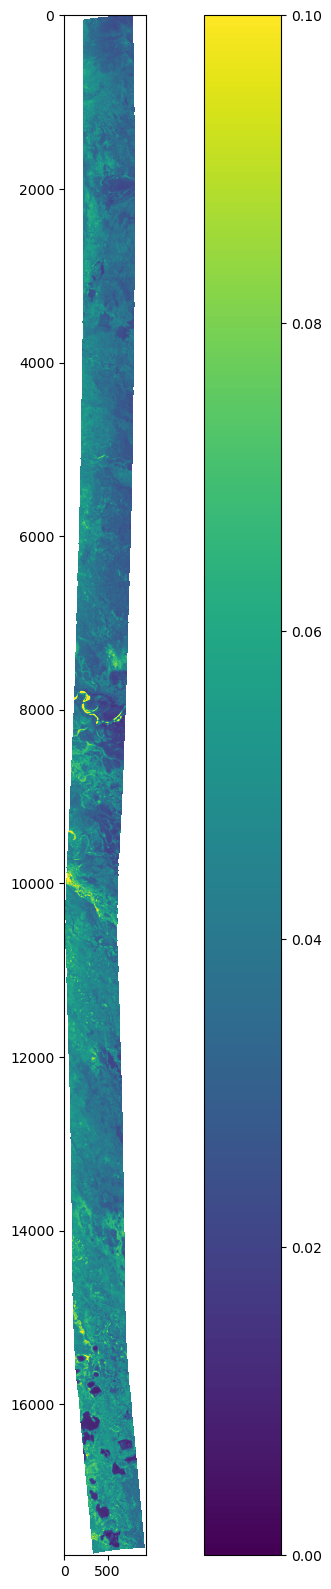

In [4]:

img_open = gdal.Open(img_file)
img_red = img_open.GetRasterBand(57).ReadAsArray()
img_red = np.where(img_red == -9999, np.nan, img_red)
plt.rcParams["figure.figsize"] = [15,20]
plt.rcParams["figure.dpi"] = 100

leimage = hyperspectral_data[:, :, 56:57]
leimage = np.where(leimage == -9999, np.nan, leimage)
plt.imshow(leimage,vmin=0, vmax=0.1)
plt.colorbar()
plt.show()

In [5]:
hyperspectral_data = np.where(hyperspectral_data < 0, 0, hyperspectral_data)

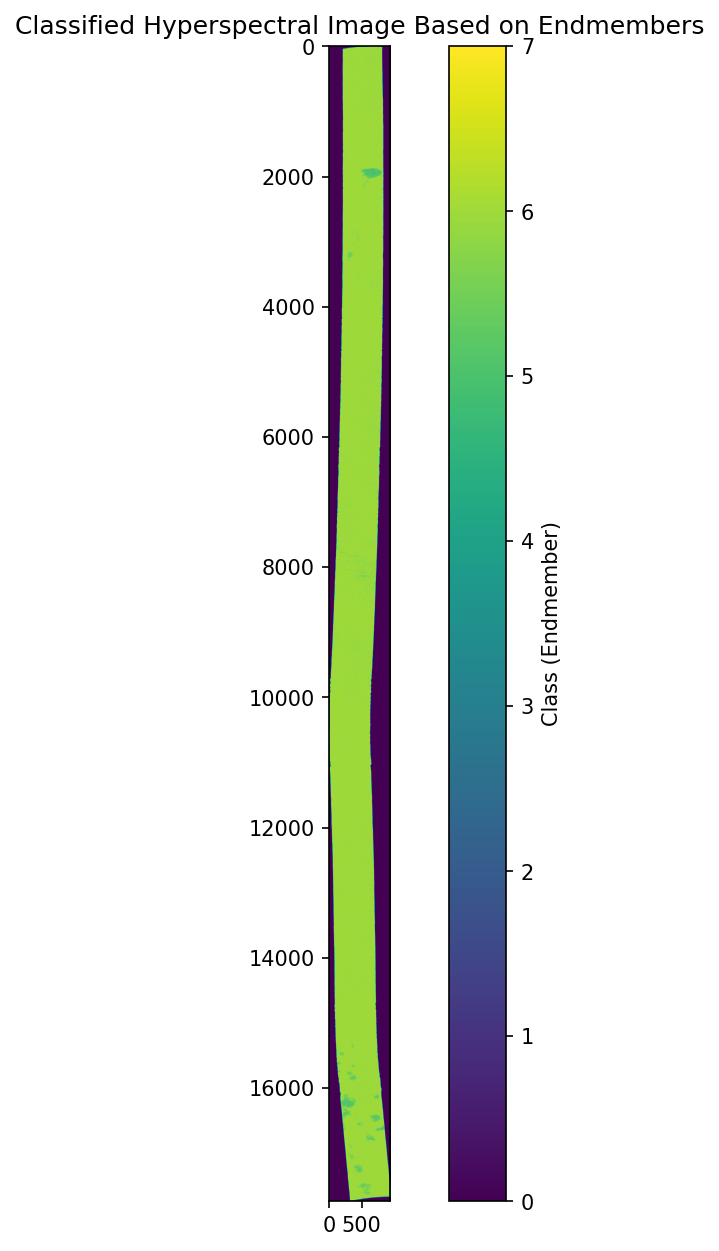

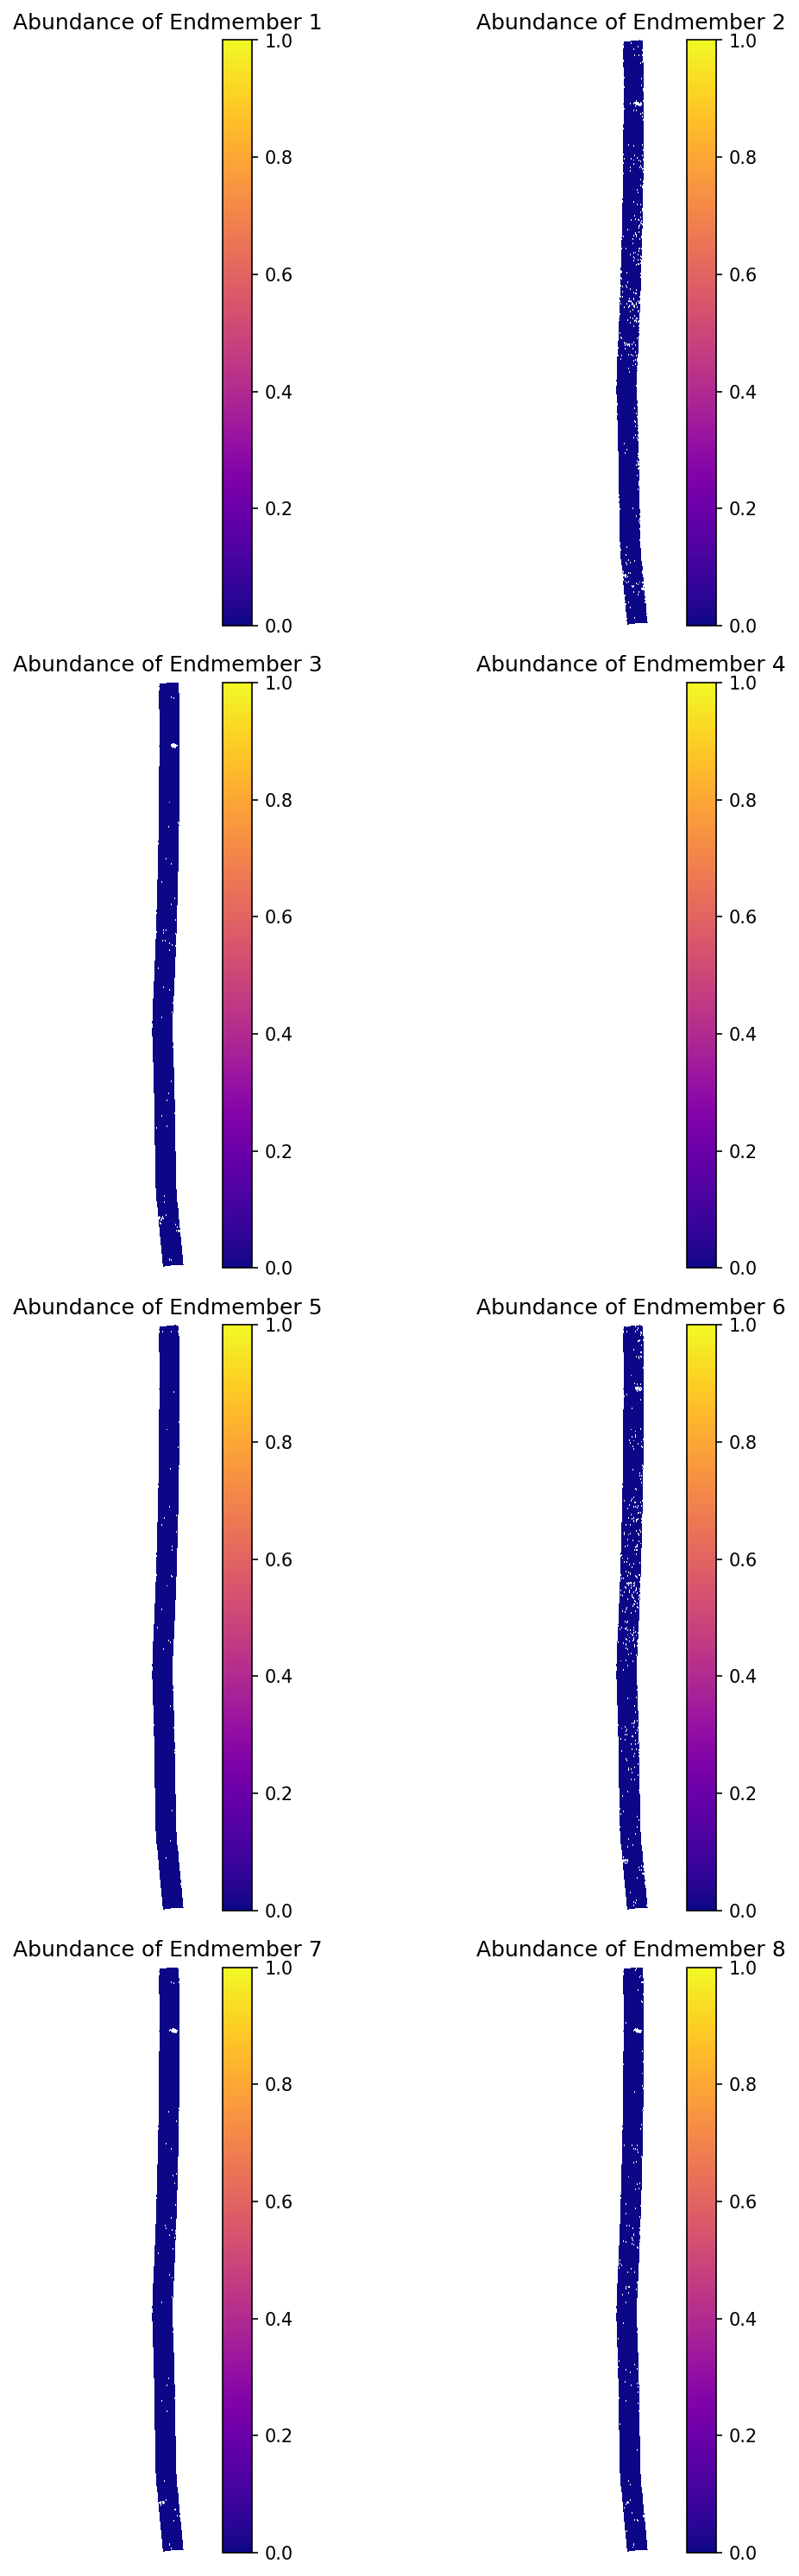

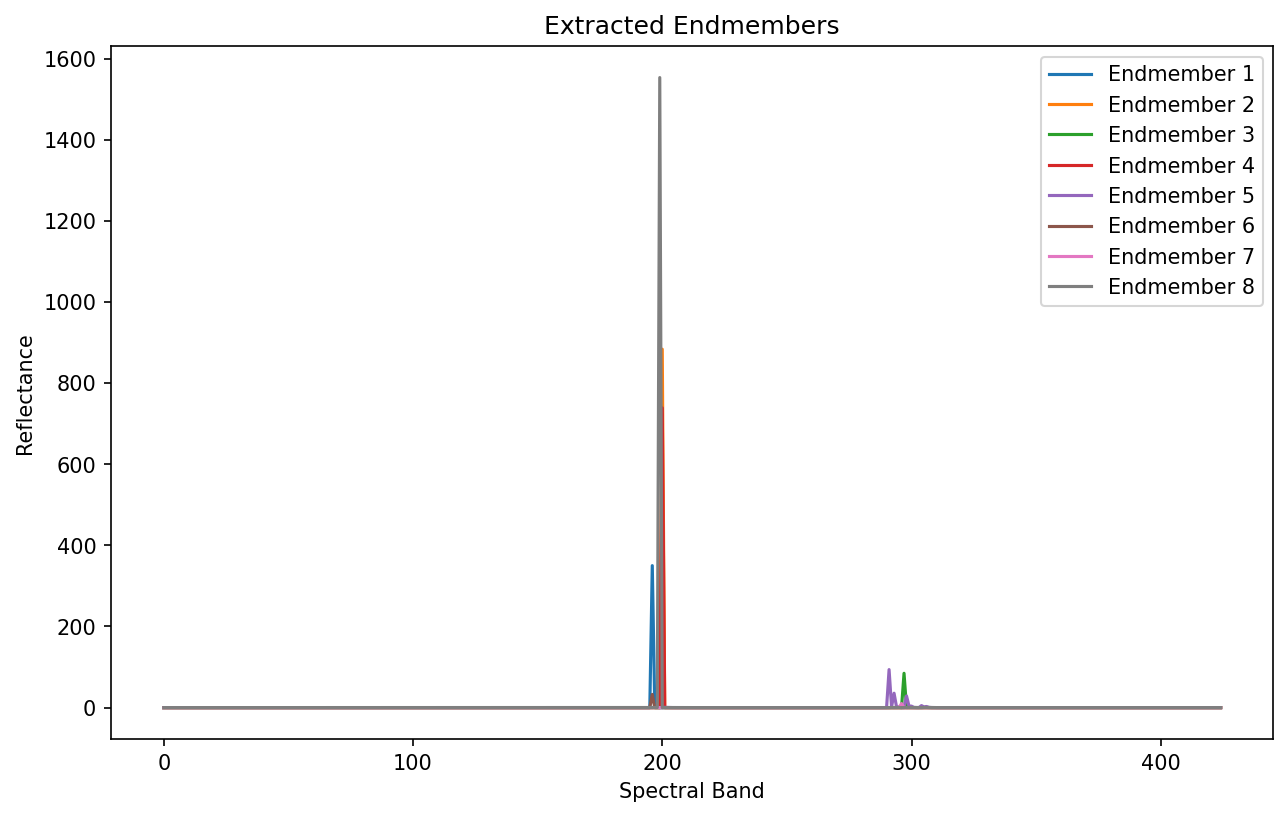

In [6]:
# Reshape data to 2D array (pixels x bands) for NNMF
reshaped_data = hyperspectral_data.reshape((rows * cols, bands))

# Define the number of endmembers
n_endmembers = 8

# Apply Non-Negative Matrix Factorization (NNMF) for spectral unmixing
nmf = NMF(n_components=n_endmembers, init='random', random_state=42)
W = nmf.fit_transform(reshaped_data)  # Abundance matrix (pixels x n_endmembers)
H = nmf.components_  # Endmember matrix (n_endmembers x bands)

# Reshape the abundance matrix back to the original image format (rows, cols, n_endmembers)
abundance_maps = W.reshape((rows, cols, n_endmembers))

# Classify the hyperspectral image based on the highest abundance for each pixel
classified_image = np.argmax(abundance_maps, axis=2)  # Index of the endmember with the highest abundance

# Define a colormap with exactly 5 distinct colors for visualization
colors = ['red', 'green', 'blue', 'yellow', 'purple']  # Customizable color choices
cmap = ListedColormap(colors)

# Visualize the classified image with a limited color palette
plt.figure(figsize=(10, 10), dpi=150)
plt.imshow(classified_image, cmap='viridis', vmin=0, vmax=n_endmembers - 1)
cbar = plt.colorbar(ticks=np.arange(n_endmembers))
cbar.set_label('Class (Endmember)')
plt.title('Classified Hyperspectral Image Based on Endmembers')
plt.show()

# Normalize the abundance maps
normalized_abundance_maps = (abundance_maps - abundance_maps.min(axis=(0, 1), keepdims=True)) / \
                            (abundance_maps.max(axis=(0, 1), keepdims=True) - abundance_maps.min(axis=(0, 1), keepdims=True))

# Dynamically calculate the grid size for abundance maps
n_rows = math.ceil(n_endmembers / 2)  # 2 columns per row
n_cols = 2  # Fixed number of columns

# Create subplots for abundance maps
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 5), dpi=150)  # Adjust figure height dynamically
axes = axes.flatten()  # Flatten the axes array for easy indexing

# Plot normalized abundance maps
for i in range(n_endmembers):
    band_data = normalized_abundance_maps[:, :, i]
    band_data = np.where(band_data == 0, np.nan, band_data)
    im = axes[i].imshow(band_data, cmap='plasma')  # Use normalized data and better colormap
    axes[i].set_title(f'Abundance of Endmember {i + 1}')
    axes[i].axis('off')  # Remove axis labels for clarity
    fig.colorbar(im, ax=axes[i], orientation='vertical')  # Add colorbars to each subplot

# Hide unused subplots (if any)
for j in range(n_endmembers, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Plot the extracted endmembers (spectral signatures)
plt.figure(figsize=(10, 6), dpi=150)
for i in range(n_endmembers):
    plt.plot(H[i], label=f'Endmember {i + 1}')
plt.xlabel('Spectral Band')
plt.ylabel('Reflectance')
plt.title('Extracted Endmembers')
plt.legend()
plt.show()